In [1]:
import credentials as cr
import SQL_requests as rq
import pandas as pd
from spotify_api import Spotify_api
from db_connect import Db_connect
from recommendation_system import Recommendation

%load_ext autoreload
%autoreload 2

## Application parameters

In [2]:
# redirect_uri = 'http://localhost/'
data_path = cr.DATA_PATH

sp = Spotify_api()
db = Db_connect()
rc = Recommendation()

## Get datas using Spotify API  
I get my personnal spotify datas using spotify api and spotify_api.py class. The Pandas dataframes created are converted into csv files which will be used to create the sqlite database.

In [3]:
playlists_df = sp.get_playlists_with_tracks()

features_df = sp.get_playlist_features(playlists_df)
features_df.drop_duplicates(inplace=True)

tracks_df = sp.get_tracks(features_df)

contains_df = sp.get_contains(playlists_df)

playlists_df.to_csv(data_path + 'playlists.csv', encoding='utf-8')
features_df.to_csv(data_path + 'features.csv', encoding='utf-8')
tracks_df.to_csv(data_path + 'tracks.csv', encoding='utf-8')
contains_df.to_csv(data_path + 'contains.csv', encoding='utf-8', index=False)

Found playlists :  28
Pop/rock kings & queens
Autoportrait
Arcades & Neons
(RPG) Leon Petersen - Don't Piss Me Off
Feel good
(RPG) Scarface - Heavy Dirty Soul
Girl Power
Alternative/Psychedelic
Musique classique
(RPG) Ashton Butler - Punkin' Shakespeare
Badass Metal
(RPG) Spooky Unicorns - Rock'N Monsters
Old Time Rock'N Roll (Kurty's playlist)
Skate It !
Favoris
Horror Circus
Ballads & Slows
(RPG) Robyn Thorn - Rockin' Girl
Top 30
(RPG) Kurt Hayward - Punk Ass
(RPG) Zak Winterscar - Broken Soldier
Accoustic
Modern Pop/Rock
Classic Rock
Ol'Retro Mood (50/60's)
Deadshot
Red Hood
Nightwing


## DataBase connect and creation

Create the SQLite database, create or update the tables with spotify datas (playlist, feature, track).

In [13]:
db.init_connection()
db.create_tables([rq.CREATE_PLAYLIST, rq.CREATE_TRACK, rq.CREATE_TRACK_FEATURES, rq.CREATE_CONTAINS])
db.insert_data(rq.INSERT_PLAYLISTS, data_path + 'playlists.csv')
db.insert_data(rq.INSERT_TRACKS_FEATURES, data_path + 'features.csv')
db.insert_data(rq.INSERT_TRACKS, data_path + 'tracks.csv')
db.insert_data(rq.INSERT_CONTAINS, data_path + 'contains.csv')
db.close_connection()

## Developping the algorithm

I start by getting the 'Top 30' (6AsIwsN6mH7dQSChLsqSlY) playlist from the database, which will be used to developp and test the algorithm.  
Let's get the first try and view the results.

In [3]:
db.init_connection()
top_30_titles = pd.read_sql_query(rq.SELECT_PLAYLIST_TITLES + "'6AsIwsN6mH7dQSChLsqSlY'", db.connector).set_index('id')
track_titles = pd.read_sql_query(rq.SELECT_TRACKS_TITLES, db.connector).set_index('id')
track_features = pd.read_sql_query(rq.SELECT_TRACKS_FEATURES, db.connector).set_index('id')
db.close_connection()

### Vizualisation of the targetted playlist :

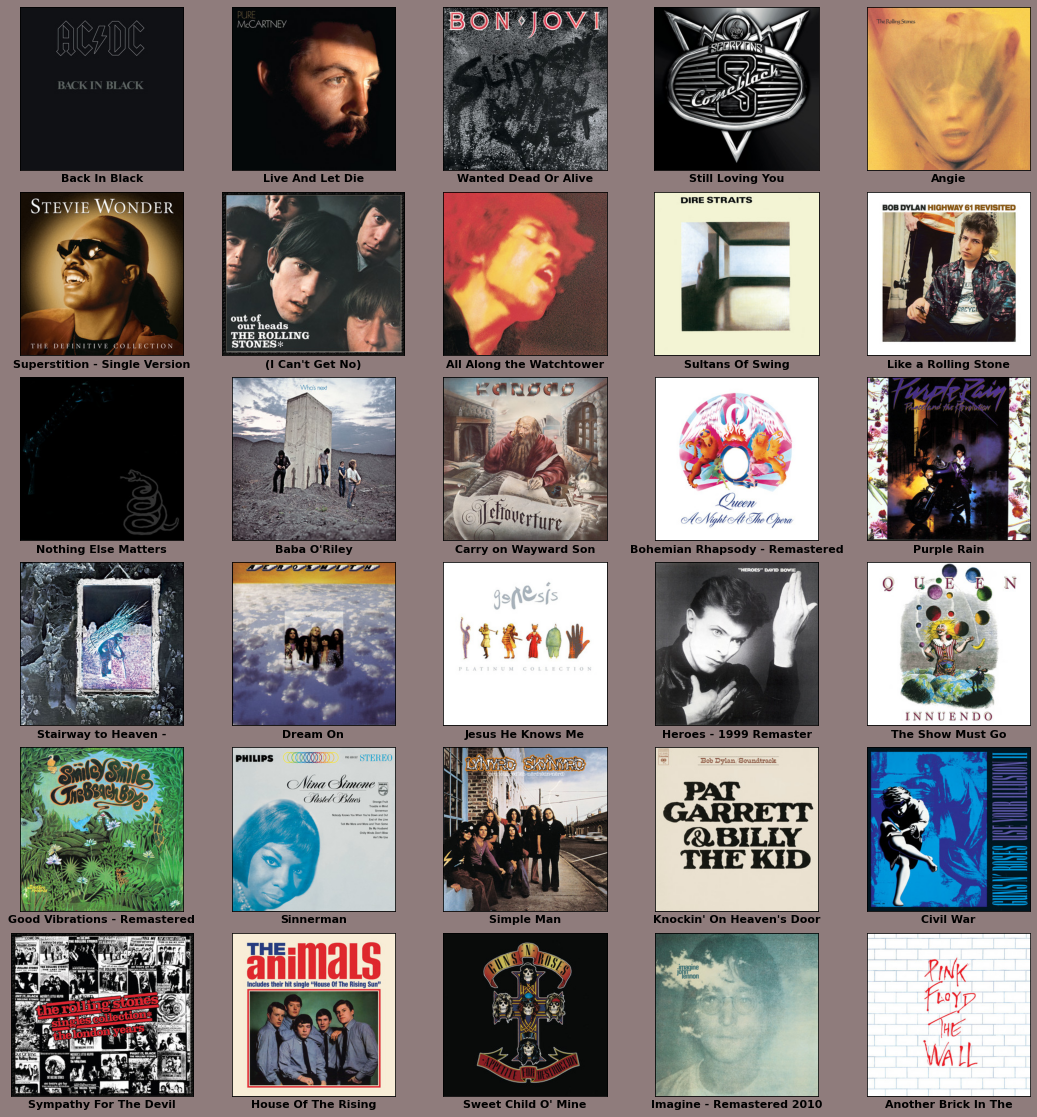

In [5]:
rc.visualize_cover(top_30_titles)

### Content-Based Recommender

#### FIrst model using nearest neighbors

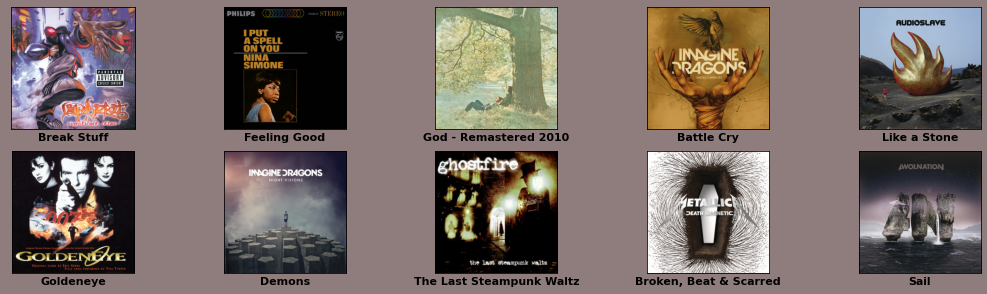

In [138]:
playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features, top_30_titles)

reco, reco_features = rc.get_recommendations(playlist, nonplaylist, track_features, track_titles)

rc.visualize_cover(reco)

In [142]:
reco.describe()

,distance,weight
count,10.000000,10.000000
mean,24.288995,1.100000
std,12.902270,0.316228
min,0.768537,1.000000
25%,16.135521,1.000000
50%,24.090530,1.000000
75%,34.997720,1.000000
max,40.299377,2.000000


In [145]:
cosine = rc.get_cosine_similarity(playlist, reco_features, track_titles)
display(cosine)

,sim,sim_mean,name,album_img
id,,,,
5cZqsjVs6MevCnAkasbEOX,"[[0.9999999039951629, 0.9999999589620987, 0.99...",1.0,Break Stuff,https://i.scdn.co/image/ab67616d00001e02378378...
6Rqn2GFlmvmV4w9Ala0I1e,"[[0.9999999707489151, 0.9999999954285951, 0.99...",1.0,Feeling Good,https://i.scdn.co/image/ab67616d00001e02425e9a...
7kipZd4tWx6Mu8kBgB2Z2r,"[[0.9999999731777018, 0.9999999961062827, 0.99...",1.0,God - Remastered 2010,https://i.scdn.co/image/ab67616d00001e02646216...
6SCDzH7OCgpzwCP8yo7HIP,"[[0.999999966225529, 0.9999999941228881, 0.999...",1.0,Battle Cry,https://i.scdn.co/image/ab67616d00001e0259ac0a...
3YuaBvuZqcwN3CEAyyoaei,"[[0.9999999887494264, 0.9999999999477842, 0.99...",1.0,Like a Stone,https://i.scdn.co/image/ab67616d00001e02a7292b...
528QhCT2v3HgD71RmrSUNW,"[[0.9999999903218955, 0.9999999995907867, 0.99...",1.0,Goldeneye,https://i.scdn.co/image/ab67616d00001e02cbb892...
2fxT5n1Q7gCgyhc2QwcmJ9,"[[0.9999999559830125, 0.9999999894301097, 0.99...",1.0,Demons,https://i.scdn.co/image/ab67616d00001e025d634b...
5ewmVuDphVDXtQYMiajbGi,"[[0.9999999627629306, 0.9999999923180621, 0.99...",1.0,The Last Steampunk Waltz,https://i.scdn.co/image/ab67616d00001e02935a31...
3BVJ1nwvdmYjXJ7gBTXTGX,"[[0.9999999950755207, 0.9999999984971351, 0.99...",1.0,"Broken, Beat & Scarred",https://i.scdn.co/image/ab67616d00001e02f58024...


In [134]:
print(cosine.sim_mean.mean())

0.9999999806289894


##### Using data processing

##### RandomizedSearchCV // GridSearch

#### Second model using cosine similarity

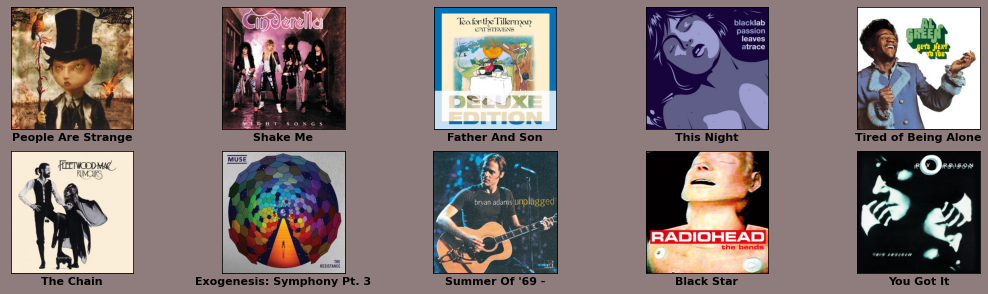

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

track_features_processed = rc.process_data(track_features)

playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features_processed, top_30_titles)
playlist_sum = playlist.sum(axis = 0)

nonplaylist_copy = nonplaylist.copy()

nonplaylist_copy['sim'] = cosine_similarity(nonplaylist.values, playlist_sum.values.reshape(1, -1))[:,0]

recommendation = nonplaylist_copy.sort_values('sim',ascending = False).head(10)
recommendation = recommendation.merge(track_titles, left_index=True, right_index=True)

recommendation.head()

rc.visualize_cover(recommendation)

In [8]:
recommendation.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5,sim,name,album_img
id,,,,,,,,,,,,,,,,,,,,,
6YAqup47jDR6QDYgILHlVX,0.000052,0.000052,0.0,0.000049,0.000053,0.000050,0.000049,0.000051,0.000649,1.0,...,0,0,0,0,0,1,0,0.867222,People Are Strange,https://i.scdn.co/image/ab67616d00001e02215dfd...
1Qjpl8Kav6rrO92ZuG0OK8,0.000056,0.000057,0.0,0.000054,0.000053,0.000053,0.000054,0.000056,0.000650,1.0,...,0,0,0,0,0,1,0,0.867222,Shake Me,https://i.scdn.co/image/ab67616d00001e028e5911...
2tbdjsdJ9xtyunKnZBkGxF,0.000054,0.000054,0.0,0.000052,0.000055,0.000052,0.000052,0.000054,0.000668,1.0,...,0,0,0,0,0,1,0,0.867222,Father And Son,https://i.scdn.co/image/ab67616d00001e024a45ab...
39zkdU2RwrLdgitEEOrGcZ,0.000040,0.000039,0.0,0.000037,0.000037,0.000038,0.000037,0.000039,0.000667,1.0,...,0,0,0,0,0,1,0,0.867222,This Night,https://i.scdn.co/image/ab67616d00001e026a417f...
10vkYRKw6Jjr7try1ir50G,0.000054,0.000052,0.0,0.000050,0.000052,0.000050,0.000050,0.000053,0.000618,1.0,...,0,0,0,0,0,1,0,0.867222,Tired of Being Alone,https://i.scdn.co/image/ab67616d00001e02fec6bb...
